# Installing and Importing Relevant Dependencies

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch_geometric as torch_geometric
import math

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
import numpy as np

from torch_geometric.datasets import TUDataset, Planetoid, BAShapes
from torch_geometric.datasets import Reddit
from torch_geometric.data import Data, DataLoader

import torch_geometric.transforms as T

#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv,GINConv
from torch.distributions import Bernoulli,Categorical

In [ ]:
from torch_geometric.datasets import BA2MotifDataset
dataset=BA2MotifDataset(root="data")

Processing...
Done!


# Downloading the Dataset

Data(x=[25, 10], edge_index=[2, 50], y=[1])


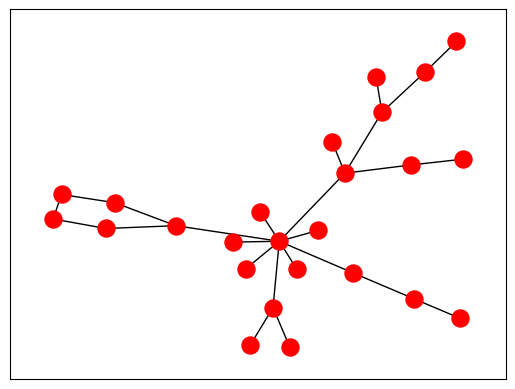

In [ ]:
from torch_geometric.utils import to_networkx
data=dataset[0]
print(data)
exgraph=to_networkx(data,to_undirected=True)
nx.draw_networkx(exgraph, node_size=150, node_color='red',with_labels=False)

# **Train-Test Split in 80:20 ratio**

In [ ]:
import random
torch.manual_seed(12345)
dataset.shuffle(dataset)
print(len(dataset))

train_dataset = dataset[:800]
test_dataset = dataset[800:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

1000
Number of training graphs: 800
Number of test graphs: 200


# Batching using a Dataloader

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3242], y=[64], batch=[1600], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3242], y=[64], batch=[1600], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3246], y=[64], batch=[1600], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3249], y=[64], batch=[1600], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3246], y=[64], batch=[1600], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3251], y=[64], batch=[1600], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3242], y=[64], batch=[1600], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3257], y

# See how a data object looks like

In [ ]:
exdata=dataset[0]
print(exdata)

Data(x=[25, 10], edge_index=[2, 50], y=[1])


# Defining and Training the Classifier

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNEncoder(torch.nn.Module):
    def __init__(self, inputdim,hidden_channels):
        super(GCNEncoder, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(inputdim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.bn(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return x

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)
class CombinedModel(torch.nn.Module):
    def __init__(self,inputdim, hidden_channels, num_classes):
        super(CombinedModel, self).__init__()
        self.encoder = GCNEncoder(inputdim,hidden_channels)
        self.classifier = LinearClassifier(input_dim=hidden_channels, num_classes=num_classes)

    def forward(self, x, edge_index, batch):
        # Get the embeddings from the encoder
        embeddings = self.encoder(x, edge_index, batch)

        # Get the logits from the classifier
        logits = self.classifier(embeddings)

        return embeddings, logits
num_features=10
inputdim=num_features
model=CombinedModel(inputdim, hidden_channels=64,num_classes=2)


In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Add a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# def train():
#     model.train()

#     for epoch in range(num_epochs):
#         for data in train_loader:  # Iterate in batches over the training dataset.
#             embedding,  out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#             #print(out)
#             loss = criterion(out, data.y)  # Compute the loss.
#             loss.backward()  # Derive gradients.
#             optimizer.step()  # Update parameters based on gradients.
#             optimizer.zero_grad()  # Clear gradients.

#         # Update the learning rate scheduler
#         scheduler.step()

#         # Print the current learning rate every epoch (optional)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}",loss)
#         # train_acc = test(train_loader)
#         # test_acc = test(test_loader)
#         # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def train():
    model.train()

    for epoch in range(num_epochs):
        for data in train_loader:  # Iterate in batches over the training dataset.
            # Forward pass
            x, edge_index, batch = data.x, data.edge_index, data.batch
            embedding, out = model(x, edge_index, batch)

            # Compute the loss
            loss = criterion(out, data.y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()

        # Print the current learning rate and loss every epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}, Loss: {loss.item()}")

# Set the number of epochs
num_epochs = 2000

# Call the training loop
train()


# # Set the number of epochs
# num_epochs = 800

# # Call the training loop
# train()



Epoch 1/2000, Learning Rate: 0.0099, Loss: 0.3005177974700928
Epoch 2/2000, Learning Rate: 0.009801, Loss: 0.6440449357032776
Epoch 3/2000, Learning Rate: 0.00970299, Loss: 0.6231232285499573
Epoch 4/2000, Learning Rate: 0.0096059601, Loss: 0.3445626497268677
Epoch 5/2000, Learning Rate: 0.009509900499, Loss: 0.5667904019355774
Epoch 6/2000, Learning Rate: 0.00941480149401, Loss: 0.5152316689491272
Epoch 7/2000, Learning Rate: 0.0093206534790699, Loss: 0.8426088094711304
Epoch 8/2000, Learning Rate: 0.0092274469442792, Loss: 0.5653101205825806
Epoch 9/2000, Learning Rate: 0.009135172474836408, Loss: 0.5057961940765381
Epoch 10/2000, Learning Rate: 0.009043820750088045, Loss: 0.5383349061012268
Epoch 11/2000, Learning Rate: 0.008953382542587164, Loss: 0.39111849665641785
Epoch 12/2000, Learning Rate: 0.008863848717161293, Loss: 0.5515310764312744
Epoch 13/2000, Learning Rate: 0.00877521022998968, Loss: 0.4282321631908417
Epoch 14/2000, Learning Rate: 0.008687458127689783, Loss: 0.325210

In [ ]:
def degree_distribution(data, N):
    # Find all unique nodes present in the edge index tensor
    all_nodes = torch.unique(torch.cat((data.edge_index[0], data.edge_index[1])))

    # Calculate the number of nodes
    num_nodes = int(all_nodes.max()) + 1 if all_nodes.numel() > 0 else 0  # If there are no nodes, set num_nodes to 0

    # Calculate the degree of each node
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)

    # Convert degrees to degree distribution
    degree_values = torch.bincount(degrees)

    # Make sure the tensor is of length N
    degree_distribution = torch.cat((degree_values, torch.zeros(max(N - len(degree_values), 0)).to(degree_values.device)))

    return degree_distribution


def clustering_coefficient(data):
    # Ensure the graph is undirected
    #data = to_undirected(data)

    # Calculate the number of nodes
    num_nodes = data.x.shape[0]

    # Calculate the number of triangles each node is involved in
    num_triangles = torch.zeros(num_nodes, dtype=torch.float)

    # Calculate the number of connected triples each node is involved in
    num_connected_triples = torch.zeros(num_nodes, dtype=torch.float)

    # Iterate over each edge in the graph
    for i, j in data.edge_index.t().tolist():
        # Get the neighbors of node i and node j
        neighbors_i = set(data.edge_index[1][data.edge_index[0] == i].tolist())
        neighbors_j = set(data.edge_index[1][data.edge_index[0] == j].tolist())

        # Calculate the number of common neighbors between i and j
        common_neighbors = neighbors_i.intersection(neighbors_j)

        # Update the number of triangles and connected triples for nodes i and j
        num_triangles[i] += len(common_neighbors)
        num_triangles[j] += len(common_neighbors)
        num_connected_triples[i] += len(neighbors_i) - 1
        num_connected_triples[j] += len(neighbors_j) - 1

    # Print intermediate results for debugging
    #print("Number of triangles per node:", num_triangles)
    #print("Number of connected triples per node:", num_connected_triples)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficient = (num_triangles / 2) / num_connected_triples
    local_clustering_coefficient[torch.isnan(local_clustering_coefficient)] = 0  # Set NaN values to 0

    # Print intermediate results for debugging
    #print("Local clustering coefficient per node:", local_clustering_coefficient)

    # Calculate the average clustering coefficient
    avg_clustering_coefficient = local_clustering_coefficient.mean()

    return avg_clustering_coefficient
import torch
import torch_geometric
import numpy as np

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues.astype(np.complex128)




In [ ]:
import torch
import torch_geometric
import numpy as np

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues

# Example usage
# Assuming 'data' is your PyTorch Geometric Data object and 'k' is the desired number of eigenvalues
# eigenvalues = spectrum_distribution(data, k)



# Function to Calculate MMD using Gaussian Kernel

In [ ]:
def mmd_kernel(X, Y, kernel_func):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples using a given kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - kernel_func: function, kernel function to compute pairwise kernel values

    Returns:
    - mmd: float, Maximum Mean Discrepancy
    """
    m, n = len(X), len(Y)

    # Compute kernel matrices
    K_xx = kernel_func(X, X)
    K_yy = kernel_func(Y, Y)
    K_xy = kernel_func(X, Y)

    # Compute MMD statistic
    mmd = 1.0 / (m * (m - 1)) * torch.sum(K_xx - torch.diag(torch.diagonal(K_xx))) + \
          1.0 / (n * (n - 1)) * torch.sum(K_yy - torch.diag(torch.diagonal(K_yy))) - \
          2.0 / (m * n) * torch.sum(K_xy)

    return mmd.item()  # Convert the result to a Python float

# Example of using a Gaussian (RBF) kernel function for PyTorch
def gaussian_kernel(X, Y, sigma=1.0):
    """
    Gaussian (RBF) kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - sigma: float, bandwidth parameter of the kernel

    Returns:
    - K: torch.Tensor, shape (n_samples, m_samples), kernel matrix
    """
    pairwise_sq_dists = torch.sum(X**2, dim=1, keepdim=True) + torch.sum(Y**2, dim=1, keepdim=True).t() - 2 * torch.mm(X, Y.t())
    K = torch.exp(-pairwise_sq_dists / (2.0 * sigma**2))
    return K




In [ ]:
max_num_nodes = max(data.x.size(0) if data.x is not None else data.edge_index.max().item() + 1 for data in dataset)
print(max_num_nodes)

25


In [ ]:
def separate_graphs_by_class(model, dataset, N):
    """
    Separates graphs in the dataset into two classes based on the model's predictions.
    Also computes latent embeddings, degree distribution, clustering coefficients,
    and spectrum distributions for each class.

    Args:
        model (torch.nn.Module): The trained GNN model for predictions.
        dataset (list): A list of graph data objects to classify.
        N (int): Number of nodes (used for computing degree distribution and spectrum).

    Returns:
        dict: A dictionary containing data, embeddings, and metrics for each class.
    """
    # Initialize containers for class-separated data
    results = {
        0: {
            "data": [],
            "latent_data": [],
            "degreedist": [],
            "cluscoeff": [],
            "spec": [],
        },
        1: {
            "data": [],
            "latent_data": [],
            "degreedist": [],
            "cluscoeff": [],
            "spec": [],
        },
    }

    for data in dataset:
        model.eval()  # Set model to evaluation mode
        embedding, out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1).item()  # Classify the graph

        # Append data and metrics to the appropriate class
        results[pred]["data"].append(data)
        results[pred]["latent_data"].append(embedding)
        results[pred]["degreedist"].append(degree_distribution(data, N))
        results[pred]["cluscoeff"].append(clustering_coefficient(data))
        results[pred]["spec"].append(spectrum_distribution(data, N))

    print(f"Class 0: {len(results[0]['data'])} graphs")
    print(f"Class 1: {len(results[1]['data'])} graphs")

    return results


In [ ]:
# Assuming model, dataset, and N are already defined
N=25
results = separate_graphs_by_class(model, dataset, N)

# Access class-specific data
data1 = results[0]["data"]
latent_data1 = results[0]["latent_data"]
degreedist1 = results[0]["degreedist"]
cluscoeff1 = results[0]["cluscoeff"]
spec1 = results[0]["spec"]

data2 = results[1]["data"]
latent_data2 = results[1]["latent_data"]
degreedist2 = results[1]["degreedist"]
cluscoeff2 = results[1]["cluscoeff"]
spec2 = results[1]["spec"]


Class 0: 512 graphs
Class 1: 488 graphs


# Graph Representation Model

In [ ]:
def GraphRepModel(N,classdata):
    B=np.zeros(N)# Node Type Matrix for nodes of 10 types
    X=np.zeros((N,10))
    numgraphs=len(classdata)
    workingdata=classdata

    #Learning the on/off bit and node representations
    for i in range(numgraphs):#len(data1))
        data=workingdata[i]
        x=data.x
        k=len(data.x) # keeping tab of the number of nodes in the ith graph
        #print(k)
        x=x.numpy()

        B[0:k]+=1
        #print(B)
        X[:x.shape[0], :] += x
    B1=B
    B=np.reshape(B,(N,-1))
    mean_estimate=X/B

    #print(mean_estimate)
    covarr=np.zeros((10,10,N))

    for i in range(numgraphs):
        data=workingdata[i]
        x=data.x
        #print(len(x))
        x=x.numpy()
        subtracted_array = x-mean_estimate[:x.shape[0], :]
        result_matrices=[]
        for row in subtracted_array:
          element = row.reshape(10, 1)  # Reshape to a 2x1 element
          result_matrix = np.dot(element, element.T)  # Multiply by its transpose
          result_matrices.append(result_matrix)

    # Concatenate the resulting 2x2 matrices along the third dimension to create a 3D array
        result_array = np.stack(result_matrices, axis=2)
        #print(result_array.shape)
        covarr[:, :, :result_array.shape[2]] += result_array
    print(covarr.shape)
    covariance_estimate=covarr/B[:,None,None]
    #print(covariance_estimate.shape)
    print(covariance_estimate.shape)
    result_list=[]
    for i in range(N):
        result_list.append(covarr[:, :, i] / B[i])

    # Convert the list of results back to a NumPy array
    result = np.stack(result_list, axis=2)
    print(result.shape)
    Bdist=B/numgraphs
    Adj=np.zeros((N,N))# Edge type count for only two types edge present/edge absent
    for i in range(len(workingdata)):
        data=workingdata[i]
        adj=data.edge_index
        rowlen=len(adj[0][:])
        #print(rowlen)
        #print(adj[:][0])
        #print(adj[:][1])
        for j in range(rowlen):
            k1=adj[0][j]
            k2=adj[1][j]
            Adj[k1][k2]+=1

    #Learning the parameters for the distribution of nodes
    #numgraphs=len(data1)
    #X=X/numgraphs #converting X to the node distribution matrix
    Adj=Adj/numgraphs
    return Bdist, mean_estimate, result, Adj


# Sampling Graphs from the Generative Model

In [ ]:
from torch_geometric.utils import to_networkx
def graphsampler(N,Bdist,mean_estimate, result, Adj,show=False):
  Bdist=np.concatenate(Bdist)
  #print(Bdist)
  samples = [np.random.choice([0, 1], p=[1 - p, p]) for p in Bdist]
  #print(samples[1])
  nodefeat=[]
  for i in range(N):
    if(samples[i]!=0):
      meanvec=mean_estimate[i,:]
      covarvec=result[:,:,i]
      normalsamples = np.random.multivariate_normal(meanvec, covarvec, 1)
      nodefeat.append(normalsamples)
  Adjacencymat=np.random.binomial(1,Adj)
  #print(Adjacencymat.shape)
  #print(Adjacencymat[3][5])
  nodefeat=np.vstack(nodefeat)

  nodefeat=torch.tensor(nodefeat)
  #nodefeat=nodefeat.double()
  #print(nodefeat)
  merged_array = np.vstack(nodefeat)
  #print(nodefeat.shape)
  k=nodefeat.shape[0]
  for i in range(N):
    for j in range(N):
      if (i>k-1 or j> k-1):
        Adjacencymat[i][j]=0
    # Convert the NumPy array to a PyTorch tensor
  adjacency_matrix = torch.tensor(Adjacencymat)

  # Find the non-zero indices in the adjacency matrix
  edge_indices = torch.nonzero(adjacency_matrix, as_tuple=False).t()
  edge_indices=edge_indices.long()
  newdata=Data(x=nodefeat,edge_index=edge_indices)
  newdata.x=newdata.x.float()
  newdata.pos=newdata.x
  #print(newdata.x.dtype)
  #print(newdata.x)
  #print(newdata.edge_index)
  embedding, out=model(newdata.x,newdata.edge_index,newdata.batch)
  soft=torch.nn.Softmax(dim=1)
  explainergraph=to_networkx(newdata,to_undirected=True)
  degreedist=degree_distribution(newdata,N)
  cluscoeffexp=clustering_coefficient(newdata)
  specdist=spectrum_distribution(newdata,N)
  if show:
    nx.draw_networkx(explainergraph, node_size=150, node_color='red',with_labels=False)

  problities=soft(out)
  explainernodes=nx.number_of_nodes(explainergraph)
  explaineredges=nx.number_of_edges(explainergraph)
  explainerdensity=(explaineredges)/(explainernodes*explainernodes)
  return problities, explainerdensity, embedding, degreedist, cluscoeffexp, specdist,explainergraph






# Calculating Metrics on the Target Class

In [ ]:
import statistics
import torch

def target_class_analysis( N,Bdist,mean_estimate,result,Adj,latent,numexplanations=50, numsample=10, label=0,show=False):
    """
    Analyzes the robustness of a target class in graph data by sampling graphs
    and evaluating accuracy, density, and other metrics.

    Args:
        X: Node feature matrix.
        Adj: Adjacency matrix.
        N: Number of nodes in the graph.
        latent: Latent space embeddings of the original data.
        numexplanations: Number of explanations to generate.
        numsample: Number of samples to generate.
        label: Target class label to analyze (default: 0).

    Returns:
        meanaccuracy: Mean accuracy.
        stdaccuracy: Standard deviation of accuracies.
        meandensity: Mean density.
        stddensity: Standard deviation of densities.
        MMD: Maximum Mean Discrepancy (MMD) distance.
        degreedistlist: Degree distributions across samples.
        cluslist: Clustering coefficients across samples.
        speclist: Spectral metrics across samples.
    """
    accuracy = []
    density = []
    embeddings = []
    degreedistlist = []
    cluslist = []
    speclist = []


    for _ in range(numexplanations):

        max_prob = 0

        for _ in range(numsample):
            probabilities, explainerdensity, embedding, degreedistb, clus, spec,explainergraph =graphsampler(N, Bdist, mean_estimate, result, Adj)

            if probabilities[0][label] > max_prob:
                sampleaccuracy = probabilities[0][label]
                sampledensity = explainerdensity
                sampleembedding = embedding
                sampledeg = degreedistb
                sampleclus = clus
                samplespec = spec
                bestgraph=explainergraph
                max_prob = probabilities[0][label]
        if show:
          nx.draw_networkx(bestgraph, node_size=150, node_color='red',with_labels=False)

        accuracy.append(sampleaccuracy)
        density.append(sampledensity)
        embeddings.append(sampleembedding)
        degreedistlist.append(sampledeg)
        cluslist.append(sampleclus)
        speclist.append(samplespec)

    meanaccuracy = torch.mean(torch.tensor(accuracy))
    stdaccuracy = torch.std(torch.tensor(accuracy))
    meandensity = statistics.mean(density)
    stddensity = statistics.stdev(density)

    MMDemb = mmd_kernel(torch.cat(latent, dim=0), torch.cat(embeddings, dim=0), gaussian_kernel)

    return meanaccuracy, stdaccuracy, meandensity, stddensity, MMDemb, degreedistlist, cluslist, speclist


# Function for Aligning the Data

In [ ]:
from torch_geometric.utils import degree
import torch

def align_data_degreewise(data_list):
    """
    Aligns the node features (`data.x`) and edges (`data.edge_index`) of a list
    of PyTorch Geometric `Data` objects degreewise in descending order.

    Args:
        data_list (list): A list of PyTorch Geometric `Data` objects.

    Returns:
        list: A new list of `Data` objects with aligned node features and edges.
    """
    aligned_data_list = []

    for data in data_list:
        # Compute the degree of each node
        node_degrees = degree(data.edge_index[0], num_nodes=data.x.size(0))

        # Get the descending order of nodes by degree
        sorted_indices = node_degrees.argsort(descending=True)

        # Reorder the node features
        aligned_x = data.x[sorted_indices]

        # Create a mapping from old node indices to new indices
        index_mapping = torch.zeros_like(sorted_indices)
        index_mapping[sorted_indices] = torch.arange(len(sorted_indices))

        # Update edge_index using the index_mapping
        aligned_edge_index = index_mapping[data.edge_index]

        # Create a new Data object with aligned features and edges
        aligned_data = data.clone()
        aligned_data.x = aligned_x
        aligned_data.edge_index = aligned_edge_index

        aligned_data_list.append(aligned_data)

    return aligned_data_list


(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)


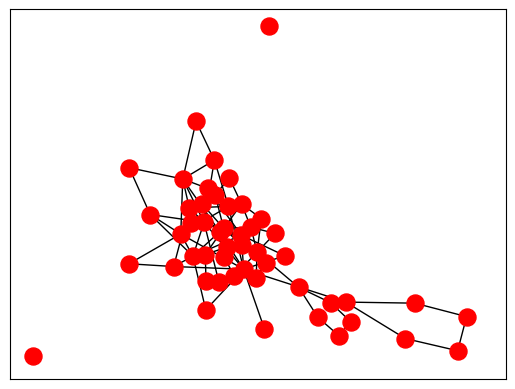

In [ ]:
data1=align_data_degreewise(data1)
data2=align_data_degreewise(data2)


N=25
Bdist, mean_estimate, result, Adj =GraphRepModel(N,data1)
latent_data=latent_data1
classlabel=0
meanaccuracy, stdaccuracy, meandensity, stddensity, MMDemb, degreedistlist, cluslist, speclist=target_class_analysis(N, Bdist, mean_estimate, result, Adj,latent_data,numexplanations=2, numsample=70, label=classlabel,show=True)


In [ ]:
print(meanaccuracy, stdaccuracy)

tensor(1.) tensor(0.)


In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data.x, data.edge_index, data.batch)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
  return boundary1 , boundary2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_error(mean, std, threshold, label, numsample,title=None, ax=None):
    """
    Plot mean with error bars.

    Parameters:
        mean (array_like): Array containing mean values.
        std (array_like): Array containing standard deviation values.
        threshold (array_like): Array containing threshold values.
        label (str): Label for the data.
        color (str): Color of the line.
        numsample (int): Sample number.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If not provided, a new figure will be created.
    """
    # Flatten the arrays
    mean=torch.tensor(mean,dtype=torch.float32)
    std=torch.tensor(std,dtype=torch.float32)
    mean = np.array(mean).flatten()
    std = np.array(std).flatten()
    threshold = np.array(threshold).flatten()
    # Select color automatically
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color = colors[numsample % 10]  # Cycle through colors

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(threshold, mean, yerr=std, fmt='-', color=color, label=f'NumSample={numsample}')  # '-' for line

    # Adding labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.legend(loc='lower right',fontsize='small')  # Show legend
    ax.grid(True)  # Add grid
# Create a figure outside the function
# fig, ax = plt.subplots()
# plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=1,ax=ax)
# plot_mean_with_error(Mean2,Std2,Threshold,label='class1',numsample=2,ax=ax)
# plt.show()


512
488
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
510
487
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
507
485
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
503
481
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
502
477
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
500
475
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
495
473
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
489
467
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
481
457
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
462
444
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
512
488
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 

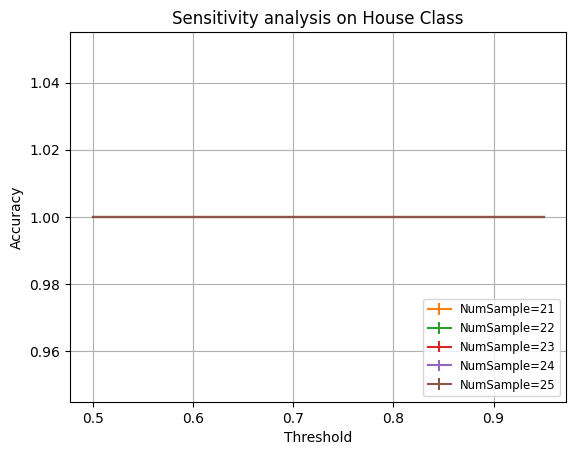

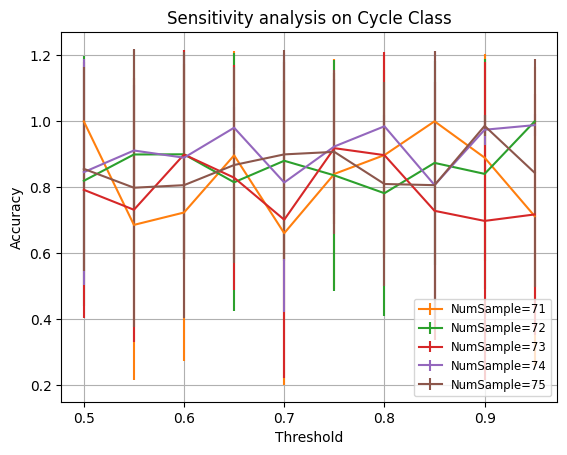

In [ ]:
samplerange=6
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
numsample1=20
numsample2=70
graphs=list(dataset)
for numsample in range(1,samplerange):
  threshold=0.5
  Threshold=[]
  Mean1=[]
  Std1=[]
  Mean2=[]
  Std2=[]

  while(threshold<1):
    Threshold.append(threshold)
    data1 , data2=Dpc(graphs,threshold)
    print(len(data1))
    print(len(data2))

    Bdist1, mean_estimate1, result1, Adj1 =GraphRepModel(N,data1)
    Bdist2, mean_estimate2, result2, Adj2 =GraphRepModel(N,data2)
    mean1,std1,*_=target_class_analysis(N, Bdist1, mean_estimate1, result1, Adj1,latent_data1,numexplanations=10, numsample=numsample1, label=0)
    Mean1.append(mean1)
    Std1.append(std1)
    mean2,std2,*_=target_class_analysis(N, Bdist2, mean_estimate2, result2, Adj2,latent_data2,numexplanations=10, numsample=numsample2, label=1)
    Mean2.append(mean2)
    Std2.append(std2)
    threshold+=0.05
  numsample1+=1
  numsample2+=1
  plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=numsample1,title='Sensitivity analysis on House Class',ax=ax1)
  plot_mean_with_error(Mean2,Std2,Threshold,label='class2',numsample=numsample2,title='Sensitivity analysis on Cycle Class',ax=ax2)

plt.show()



In [ ]:
Bdist1, mean_estimate1, result1, Adj1 =GraphRepModel(N,data1)
Bdist2, mean_estimate2, result2, Adj2 =GraphRepModel(N,data2)
mean_estimates=[mean_estimate1,mean_estimate2]
covar_estimates=[result1,result2]

(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)
(10, 10, 25)
(25, 10, 10, 25)
(10, 10, 25)


In [ ]:
mixcoeff=0.5
Bdistmix=mixcoeff*Bdist1+(1-mixcoeff)*Bdist2
Adjmix=mixcoeff*Adj1+(1-mixcoeff)*Adj2


In [ ]:
import torch

def boundary_analysis(N, Bdistmix, mean_estimates,covar_estimates, Adj,numboundary, numsample, label1, label2):
    accuracies = []
    embeddings = []

    for _ in range(numboundary):
        min_difference = float('inf')
        sample_accuracy = None
        sample_embedding = None
        mean_estimate=random.choice(mean_estimates)
        result=random.choice(covar_estimates)

        for _ in range(numsample):
            probabilities, _, embedding,*_ = graphsampler(N, Bdist, mean_estimate, result, Adj)

            # Difference in class scores
            score_diff = abs(probabilities[0][label1] - probabilities[0][label2])

            if score_diff < min_difference:
                min_difference = score_diff
                sample_accuracy = probabilities[0][label1]
                sample_embedding = embedding

        accuracies.append(sample_accuracy)
        embeddings.append(sample_embedding)

    # Calculate mean and standard deviation of accuracies
    mean_accuracy = torch.mean(torch.tensor(accuracies))
    std_accuracy = torch.std(torch.tensor(accuracies))

    return mean_accuracy, std_accuracy, embeddings



In [ ]:
bdmean,bdstd,embeddings=boundary_analysis(N, Bdistmix, mean_estimates,covar_estimates, Adjmix,10, 2000, 0, 1)
print(bdmean,bdstd)


tensor(0.4787) tensor(0.0650)


In [ ]:
# Computing boundary metrics
import torch
import torch.nn.functional as F

def boundary_margin(embeddings_c1, embeddings_c2):
    """
    Compute the boundary margin.

    Args:
    - embeddings_c1 (torch.Tensor): Embeddings of class c1 graphs.
    - embeddings_c2 (torch.Tensor): Embeddings of boundary graphs between class c1 and c2.

    Returns:
    - margin (float): The boundary margin.

    """
    embeddings_c1=torch.cat(embeddings_c1,dim=0)
    embeddings_c2=torch.cat(embeddings_c2,dim=0)
    distances = torch.norm(embeddings_c1 - embeddings_c2, dim=1)
    margin = torch.min(distances).item()
    return margin

def boundary_thickness(embeddings_c1, embeddings_c1_c2, model, c1, c2, gamma=0.75, num_points=100):
    thickness_values = []

    for emb_c1, emb_c1_c2 in zip(embeddings_c1, embeddings_c1_c2):
        t_values = torch.linspace(0, 1, num_points)
        h_t = (1 - t_values).unsqueeze(1) * emb_c1 + t_values.unsqueeze(1) * emb_c1_c2
        #print(model(h_t).size())

        # Compute the logits
        logits_h_t = model(h_t)  # Assuming `model` is your classifier
        probs_h_t = F.softmax(logits_h_t, dim=1)

        # Compute the integrand
        integrand = (gamma > (probs_h_t[:, c1] - probs_h_t[:, c2])).float()

        # Approximate the integral using the trapezoidal rule
        integral = torch.trapz(integrand, t_values)

        # Compute the thickness value
        thickness_value = (emb_c1 - emb_c1_c2).norm() * integral.mean()
        thickness_values.append(thickness_value.item())

    return sum(thickness_values) / len(thickness_values)

# def boundary_complexity(embeddings, D):
#     """
#     Compute the boundary complexity.

#     Args:
#     - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
#     - D (int): Dimensionality of the embeddings.

#     Returns:
#     - complexity (float): The boundary complexity.
#     """
#     # Compute the covariance matrix of the embeddings
#     embeddings=torch.cat(embeddings,dim=0)
#     covariance_matrix = torch.cov(embeddings.T)

#     # Compute the eigenvalues of the covariance matrix
#     eigenvalues = torch.linalg.eigvalsh(covariance_matrix)
#     print(eigenvalues)

#     # Normalize the eigenvalues
#     eigenvalues_normalized = eigenvalues / eigenvalues.sum()
#     print(eigenvalues_normalized)

#     # Compute the entropy of the normalized eigenvalues
#     entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + 1e-7))
#     print(entropy)

#     # Normalize the entropy by dividing it by log(D)
#     complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

#     return complexity.item()
def boundary_complexity(embeddings, D, epsilon=1e-7):
    """
    Compute the boundary complexity.

    Args:
    - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
    - D (int): Dimensionality of the embeddings.
    - epsilon (float): Small value added to eigenvalues to prevent log(0).

    Returns:
    - complexity (float): The boundary complexity.
    """
    # Flatten and concatenate embeddings
    embeddings = torch.cat(embeddings, dim=0)

    # Compute the covariance matrix of the embeddings
    covariance_matrix = torch.cov(embeddings.T)

    # Add a small value to the diagonal for regularization
    covariance_matrix += epsilon * torch.eye(covariance_matrix.size(0))

    # Compute the eigenvalues of the covariance matrix
    eigenvalues = torch.linalg.eigvalsh(covariance_matrix)

    # Clamp eigenvalues to avoid very small negative values due to numerical errors
    eigenvalues = torch.clamp(eigenvalues, min=epsilon)

    # Normalize the eigenvalues
    eigenvalues_normalized = eigenvalues / eigenvalues.sum()

    # Compute the entropy of the normalized eigenvalues
    entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + epsilon))

    # Normalize the entropy by dividing it by log(D)
    complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

    return complexity.item()

In [ ]:
boundaryembeddings=embeddings
latent_data=latent_data2
margin=boundary_margin(boundaryembeddings[:len(latent_data)],latent_data)
print(margin)
thickness=boundary_thickness(boundaryembeddings[:len(latent_data)],latent_data,model.classifier,1,0)
print(thickness)
complexity=boundary_complexity(boundaryembeddings[:len(latent_data)],64)
print(complexity)

RuntimeError: The size of tensor a (10) must match the size of tensor b (488) at non-singleton dimension 0

Plot the Confusion Matrix of the Classifier

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataset, class_dict):
    """
    Evaluate the model on the provided dataset, compute the confusion matrix,
    and plot it with class names.

    Parameters:
    - model: Trained GNN model
    - dataset: List of data objects
    - class_dict: Dictionary mapping class labels to class names, e.g., {0: 'Class A', 1: 'Class B'}
    """

    # Step 1: Evaluate the model and get predictions and true labels
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataset:
            _, out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Step 2: Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Step 3: Plot the confusion matrix
    class_names = [class_dict[i] for i in range(len(class_dict))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming the class labels are {0: 'Mutagenic', 1: 'Non-Mutagenic'}
#class_dict = {0: 'Mutagenic', 1: 'Non-Mutagenic'}

# Example dataset (assuming it's a list of data objects)
# dataset = [...]

# Call the function with the model, dataset (as a list), and class dictionary
#plot_confusion_matrix(model, dataset, class_dict)


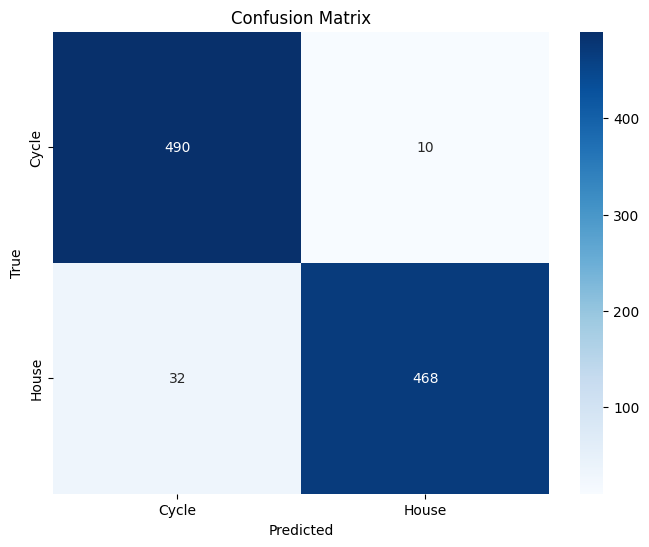

In [ ]:
class_dict={0:'Cycle',1:'House'}
plot_confusion_matrix(model,dataset,class_dict)